In [18]:
import os
import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import BaseCrossValidator, TimeSeriesSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

In [19]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)

## Вспомогательные функции

In [8]:
def plot_pr_curve(test_y, predictions):
    precision, recall, _ = precision_recall_curve(test_y, predictions)
    plt.plot(recall, precision, marker='.', label='catboost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_fit_curves(model):
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['learn']['AUC'],
        label='learn'
    )
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['validation']['AUC'],
        label='val'
    )
    plt.legend()
    plt.show()

def plot_target_segment(test_y, predictions):
    hist_df = pd.DataFrame(
        {
            'target':test_y.values,
            'proba':predictions
        }
    )
    hist_df = hist_df.sort_values(by='proba', ascending=False)
    
    num_segments = 20
    segment_length = len(hist_df) // num_segments
    array_21 = [21]*(len(hist_df)-num_segments*segment_length)
    hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21
    
    hist_df = hist_df.groupby('segment')['target'].sum()
    plt.bar(list(hist_df.index), list(hist_df.values))
    plt.show()

def plot_shap(model, df):
    zero_df = df.loc[df['target']==0].drop(['target','report_date'],axis=1).sample(100)
    one_df = df.loc[df['target']==1].drop(['target','report_date'],axis=1)
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(zero_df)
    )
    shap.summary_plot(
        shap_values, 
        zero_df
    )
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(one_df)
    )
    shap.summary_plot(
        shap_values, 
        one_df
    )

def fit_catboost(pool_train, pool_val):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        eval_metric='AUC:hints=skip_train~false',
        random_seed=1
    )
    
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=False
    )
    return model

## Коннект к mlflow

In [9]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'denis_test')
client = MlflowClient()

## Датасет

In [10]:
fa = pd.read_parquet('data/factor_analysis.parquet')

cat_cols = [
    'col520', 'col552', 'col543', 'col527', 'col607', 'col600', 'col599',
    'col560', 'col548', 'col551', 'col535', 'col540', 'col464', 'col152',
    'col228', 'col559', 'col460', 'col472', 'col568', 'col468'
]
features = (
    list(fa
    .loc[
        (fa['not_null_percent']>0.05)
        & (fa['mode_frequency']<0.8)
        & (fa['ind_gini']>0.001),
        'feature_name'
    ].unique())
)
features = ['report_date', 'client_id', 'target'] + cat_cols + list(features)
print(len(features))
df = pd.read_parquet(
    'data/data_v1',
    columns=features
)

last_3m = sorted(df['report_date'].unique())[-3:]

train_df = (
    df[~df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['client_id'], axis=1)
)

test_df = (
    df[df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['report_date', 'client_id'], axis=1)
)

902


In [653]:
# zeros = train_df.loc[train_df['target']==0].sample(frac=0.05)
# train_df = train_df.loc[train_df['target']!=0]
# train_df = pd.concat([train_df,zeros])

## Модель

### Обычная тренировка

0.18198782938146887
0.9128343241095587


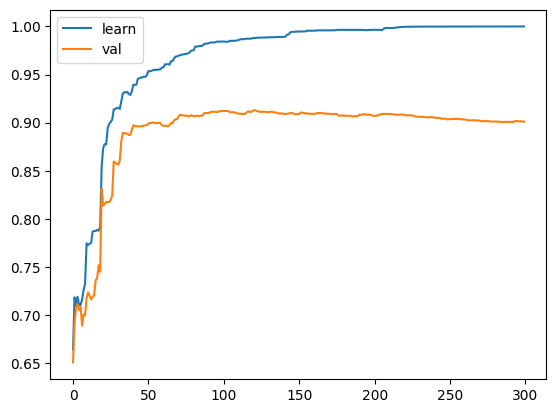

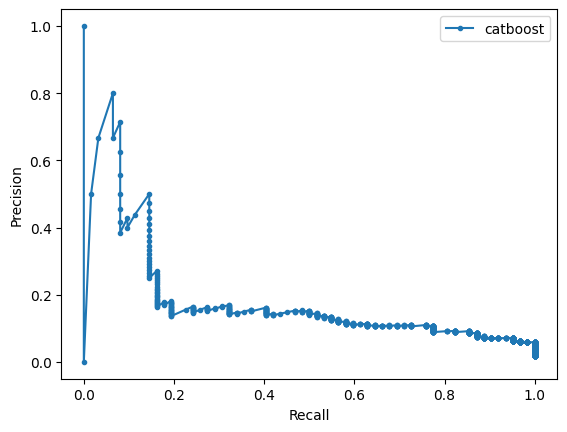

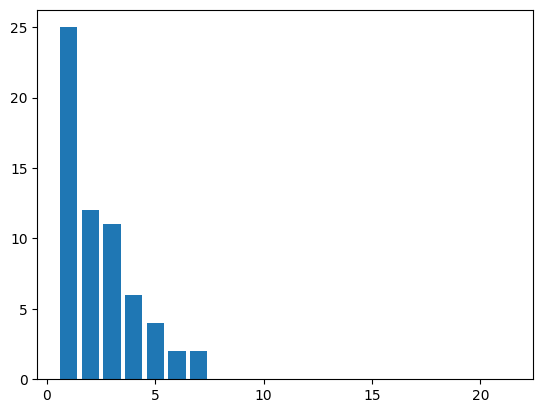

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


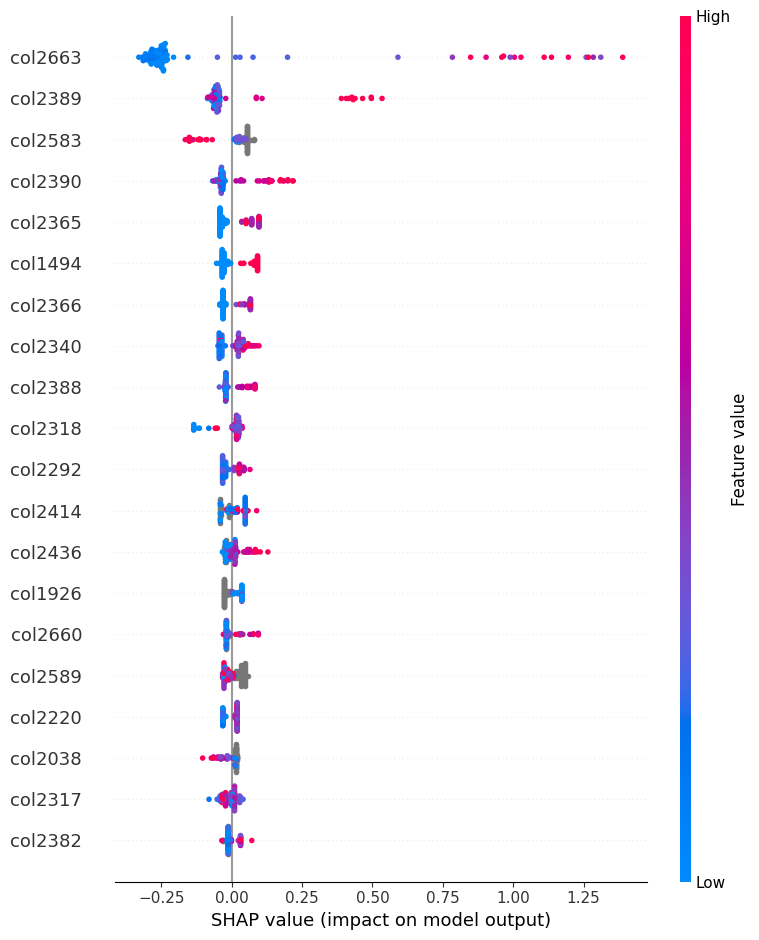

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


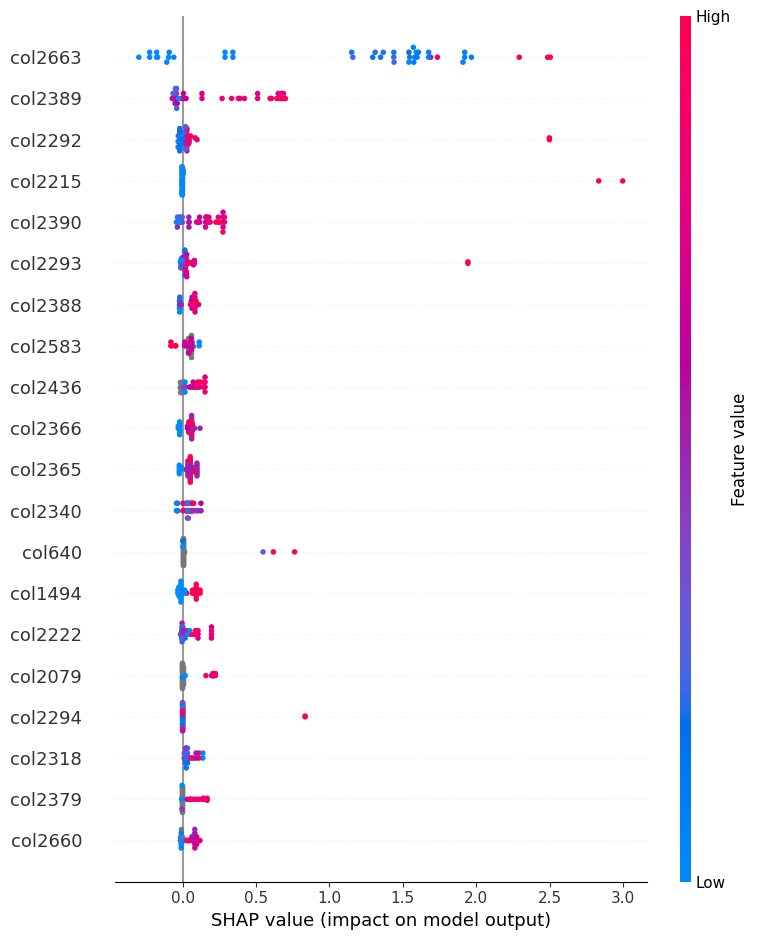

In [641]:
train_df = train_df.loc[train_df['report_date'].isin(['2022-11-01', '2022-10-01'])]

pool_train = Pool(
    train_df.drop(['target', 'report_date'], axis=1),
    train_df['target'],
    cat_features = list(
        train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop('target', axis=1),
    test_df['target'],
    cat_features = list(
        train_df.drop('target', axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = fit_catboost(pool_train,pool_val)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_pr_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, train_df)

### Можно ли отсечь часть выборки по пропускам
На shap замечено, что пропуски в некоторых фичах существенно влияют на предсказание. Можно ли до обучения модели отсечь часть выборки?

In [634]:
columns = [
    'col2583','col1926', 'col2083', 'col2586', 'col640', 
    'col2079', 'col2379', 'col1459', 'col1468', 'col1902',
    'col1466', 'col1836', 'col1901'
]
for col_name in columns:
    column = train_df[[col_name, 'target']].copy()
    column[col_name] = column[col_name].fillna(-1)
    column.loc[column[col_name]!=-1, col_name] = 1
    display(column.groupby(col_name)['target'].sum())

col2583
-1.0    152
 1.0    222
Name: target, dtype: int64

col1926
-1.0    209
 1.0    165
Name: target, dtype: int64

col2083
-1.0    331
 1.0     43
Name: target, dtype: int64

col2586
-1.0    349
 1.0     25
Name: target, dtype: int64

col640
-1.0    356
 1.0     18
Name: target, dtype: int64

col2079
-1.0    339
 1.0     35
Name: target, dtype: int64

col2379
-1.0    143
 1.0    231
Name: target, dtype: int64

col1459
-1.0    198
 1.0    176
Name: target, dtype: int64

col1468
-1.0    198
 1.0    176
Name: target, dtype: int64

col1902
-1.0    209
 1.0    165
Name: target, dtype: int64

col1466
-1.0    198
 1.0    176
Name: target, dtype: int64

col1836
-1.0    209
 1.0    165
Name: target, dtype: int64

col1901
-1.0    209
 1.0    165
Name: target, dtype: int64

In [639]:
print(train_df['col640'].isna().sum())
print(len(train_df['col640']))

10632
11187


Вывод - нельзя отсечь часть выборки по пропускам, чтобы существенно уменьшить саму выборку, но несущественно повлиять на число таргетов

### На скольки датах лучше тренироваться, чтобы предсказать тестовые 3 месяца?
### В каком соотношении лучше брать семпл ноликов для каждого набора дат?

In [7]:
list_dates = [
    ['2022-11-01'],
    ['2022-11-01', '2022-10-01'],
    ['2022-11-01', '2022-10-01', '2022-09-01'],
    ['2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01'],
    ['2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01', '2022-07-01'],
    ['2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01', '2022-07-01', '2022-06-01']
]
samples = [
    1,2,3,4,5,6,7,8,9,10
]

len_dates = []
samples_ = []
pr_auc = []
roc_auc = []

for date in tqdm(list_dates):
    for sample in tqdm(samples):
        len_dates.append(len(date))
        samples_.append(sample)
        train_df_ = train_df.loc[train_df['report_date'].isin(date)]
        len_1 = len(train_df_[train_df_['target']!=0])
        zeros = train_df_.loc[train_df_['target']==0].sample(len_1*sample, random_state=1)
        train_df_ = train_df_.loc[train_df['target']!=0]
        train_df_ = pd.concat([train_df_,zeros])
        
        pool_train = Pool(
        train_df_.drop(['target', 'report_date'], axis=1),
            train_df_['target'],
            cat_features = list(
                train_df.drop(['target', 'report_date'], axis=1)
                .select_dtypes(include=['object'])
                .columns
            )
        )
        
        pool_val = Pool(
            test_df.drop('target', axis=1),
            test_df['target'],
            cat_features = list(
                test_df.drop('target', axis=1)
                .select_dtypes(include=['object'])
                .columns
            )
        )
        
        model = fit_catboost(pool_train,pool_val)

        predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
        precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
        pr_auc.append(auc(recall, precision))
        roc_auc.append(roc_auc_score(test_df['target'], predictions))

100%|██████████| 6/6 [09:40<00:00, 96.74s/it] 


In [18]:
date_sample = pd.DataFrame(
    {
        'len_dates':len_dates,
        'samples':samples_,
        'pr_auc':pr_auc,
        'roc_auc':roc_auc
    }
)
display(date_sample.sort_values(by='roc_auc', ascending=False))
date_sample.to_parquet('data/date_sample.parquet')

,len_dates,samples,pr_auc,roc_auc
45,5,6,0.221433,0.918495
47,5,8,0.258819,0.913699
11,2,2,0.229737,0.912241
19,2,10,0.272937,0.911979
52,6,3,0.248723,0.911783
10,2,1,0.221453,0.911698
48,5,9,0.238714,0.911469
49,5,10,0.184477,0.909631
59,6,10,0.211362,0.908977
46,5,7,0.215387,0.908275


Наилучших метрик достигаем при обучение на 5ти датах и семплировании 7 к 1

## Насколько сильно влияет рандомное сеплирование на метрики?

In [ ]:
dates = ['2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01', '2022-07-01']

pr_auc = []
roc_auc = []

for i in tqdm(range(20)):
    train_df_ = train_df.loc[train_df['report_date'].isin(date)]
    len_1 = len(train_df[train_df['target']!=0])
    zeros = train_df_.loc[train_df_['target']==0].sample(len_1*7)
    train_df_ = train_df_.loc[train_df['target']!=0]
    train_df_ = pd.concat([train_df_,zeros])
    pool_train = Pool(
    train_df_.drop(['target', 'report_date'], axis=1),
        train_df_['target'],
        cat_features = list(
            train_df.drop(['target', 'report_date'], axis=1)
            .select_dtypes(include=['object'])
            .columns
        )
    )
    
    pool_val = Pool(
        test_df.drop('target', axis=1),
        test_df['target'],
        cat_features = list(
            test_df.drop('target', axis=1)
            .select_dtypes(include=['object'])
            .columns
        )
    )
    
    model = fit_catboost(pool_train,pool_val)

    predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
    precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
    pr_auc.append(auc(recall, precision))
    roc_auc.append(roc_auc_score(test_df['target'], predictions))

print('Средний pr_auc =', np.mean(pr_auc))
print('Средний roc_auc =', np.mean(roc_auc))
print('Стандартное отклонение pr_auc =', np.std(pr_auc))
print('Стандартное отклонение roc_auc =', np.std(roc_auc))

## Выгружаем артефакты модели на mlflow

In [14]:
predictions  = model.predict(X_test[shap_rfe])
signature = infer_signature(X_test[shap_rfe], predictions)
metrics_to_mlflow = {
    'pr_auc':auc_precision_recall,
    'roc_auc':roc_auc
}

with mlflow.start_run(run_name=f'denis_test1'):
    mlflow.log_params(hyperparams)
    mlflow.log_param('null_thresh', null_thresh)
    mlflow.log_param('mode_thresh', mode_thresh)
    mlflow.log_param('gini_thresh', gini_thresh)
    mlflow.log_metrics(metrics_to_mlflow)
    mlflow.sklearn.log_model(
        model,
        signature=signature,
        registered_model_name=f'LGBM',
        artifact_path=''
    )
    mlflow.set_tags({'model': 'lgbm'})
    mlflow.log_artifacts('/data')
    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
mlflow.end_run()

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\_distutils_hack\__init__.py:24: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\_distutils_hack\__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'model_tree_v1' already exists. Creating a new version of this model...
2023/09/08 17:00:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: model_tree_v1, version 2
Created version '2' of model 'model_tree_v1'.

Model saved in run c7b833fdf4724537b7589b84bdd66c3f
